In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import litellm
import os
import base64
from pathlib import Path
from litellm.caching import Cache
from litellm import completion, acompletion

In [3]:
from diffusers import AutoencoderKL
import torch

ae = AutoencoderKL.from_pretrained("black-forest-labs/FLUX.1-schnell", torch_dtype=torch.bfloat16, subfolder="vae")

In [4]:
import numpy as np
imgs_path = "images_itda/0.npz"
nf4 = np.asarray(
    [
        -1.0,
        -0.6961928009986877,
        -0.5250730514526367,
        -0.39491748809814453,
        -0.28444138169288635,
        -0.18477343022823334,
        -0.09105003625154495,
        0.0,
        0.07958029955625534,
        0.16093020141124725,
        0.24611230194568634,
        0.33791524171829224,
        0.44070982933044434,
        0.5626170039176941,
        0.7229568362236023,
        1.0,
    ]
)
latent = np.load(imgs_path)["arr_0"][None]
latent = np.stack((latent & 0x0F, (latent & 0xF0) >> 4), -1).reshape(*latent.shape[:-1], -1)
latent = nf4[latent]
latent = latent * 5.0

In [5]:
def latent_to_img(latent: np.ndarray) -> np.ndarray:
    latent = latent[None]
    latent = np.stack((latent & 0x0F, (latent & 0xF0) >> 4), -1).reshape(*latent.shape[:-1], -1)
    latent = nf4[latent]
    latent = latent * 5.0

    image = ae.decode(z=torch.from_numpy(latent / ae.config.scaling_factor + ae.config.shift_factor).to(torch.bfloat16)).sample
    image_np = ((image + 1) * 127).clip(0, 255).to(torch.uint8).numpy().squeeze().transpose(1, 2, 0)

    return image_np

In [6]:
from hashlib import md5
latent_cache_path = Path("latent_cache_itda")
latent_cache_path.mkdir(exist_ok=True)
def path_to_img(path: str) -> np.ndarray:
    cached_npz_path = (latent_cache_path / md5(str(path).encode()).hexdigest()).with_suffix(".npz")
    if cached_npz_path.exists():
        return np.load(cached_npz_path)["arr_0"]
    arr = latent_to_img(np.load(path)["arr_0"])
    np.savez_compressed(cached_npz_path, arr)
    return arr

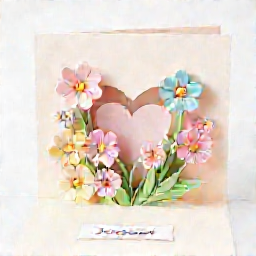

In [7]:
from PIL import Image
image = ae.decode(z=torch.from_numpy(latent / ae.config.scaling_factor + ae.config.shift_factor).to(torch.bfloat16)).sample
image_np = ((image + 1) * 127).clip(0, 255).to(torch.uint8).numpy().squeeze().transpose(1, 2, 0)
image_pil = Image.fromarray(image_np)
image_pil

In [8]:
DISK_CACHE_DIR = Path(".dspy_cache")
DISK_CACHE_LIMIT = 1e10 # 10 GB

litellm.cache = Cache(disk_cache_dir=DISK_CACHE_DIR, type="disk")

if litellm.cache.cache.disk_cache.size_limit != DISK_CACHE_LIMIT:
    litellm.cache.cache.disk_cache.reset("size_limit", DISK_CACHE_LIMIT)

litellm.telemetry = False

# Turn off by default to avoid LiteLLM logging during every LM call.
litellm.suppress_debug_info = True

ModuleNotFoundError: No module named 'diskcache'

In [9]:
from PIL import Image
import io

def encode_image(image_pil: Image):
    png_bytes = io.BytesIO()
    image_pil.save(png_bytes, format="PNG")
    return base64.b64encode(png_bytes.getvalue()).decode("utf-8")

base64_image = encode_image(Image.open("cat.jpeg"))
messages = [{
    "role": "user",
    "content": [{
        "type": "text",
        "text": "Describe this image"
    }, {
        "type": "image_url",
        "image_url": {
            "url":  f"data:image/jpeg;base64,{base64_image}"
        }
    }]
}]

In [10]:
response = completion(
  model="openai/google/gemini-2.0-flash-001",
  messages=messages,
  base_url="https://openrouter.ai/api/v1",
)

print(response.choices[0].message.content)

Here's a description of the image:

**Overall Impression:**

This is a heartwarming portrait of a young, light-colored kitten. The kitten is looking upwards and slightly to the right, giving the image a sense of curiosity and wonder.
**Kitten Detail:**

*   **Coat:** The kitten has a pale, creamy fur, possibly a light ginger or buff color.
*   **Eyes:** It boasts striking, deep blue eyes that stand out against its light fur.
*   **Expression:**  Its expression is gentle and attentive, with slightly parted mouth.
*   **Pose:** The kitten is partially visible, as if peering over the edge of something. Its paws are resting on what it's looking over, adding to the image's endearing quality.
*   **Whiskers:** Long, delicate whiskers extend from its muzzle.

**Background and Surroundings:**
*   **Material:** The kitten is resting on a soft, plush leopard-print surface.
*   **Atmosphere:** The lighting appears to be soft and professionally done.

**Overall Impression:**
The image evokes a sen

In [11]:
from huggingface_hub import HfApi
api = HfApi()

images_zip = api.hf_hub_download("nev/flux1-saes", filename="maxacts_double_l18_img/images.zip")

In [12]:
image_activations_zip = api.hf_hub_download("nev/flux1-saes", filename="maxacts_double_l18_img/image_activations.zip")

In [13]:
import zipfile

# with zipfile.ZipFile(images_zip, 'r') as zip_ref:
#     zip_ref.extractall("images_saes")

In [14]:
# with zipfile.ZipFile(image_activations_zip, 'r') as zip_ref:
#     zip_ref.extractall("image_activations_saes")

In [15]:
maxacts_folder = Path("itda_data_2")

In [16]:
images_folder = Path("images_itda_2")
image_activations_folder = Path("image_activations_itda_2")

In [17]:
img_path = images_folder / "1.npz"

img = np.load(img_path, allow_pickle=True)["arr_0"]

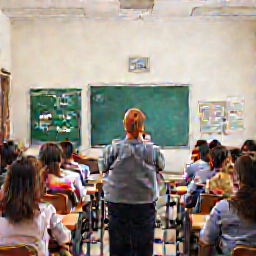

In [18]:
image_pil = Image.fromarray(latent_to_img(img))
image_pil

In [19]:
acts_bd = np.load(maxacts_folder / "feature_acts.db.npy")

In [20]:
from scored_storage import ScoredStorage

top_k_activations = 1024
scored_storage = ScoredStorage(
    maxacts_folder / "feature_acts.db",
    3, 32,
    mode="r", use_backup=True
)

2025-02-28 20:05:08.361 | INFO     | scored_storage:__init__:77 - Opening database itda_data_2/feature_acts.db for reading.
2025-02-28 20:05:08.364 | INFO     | scored_storage:__init__:86 - Database itda_data_2/feature_acts.db opened successfully.


In [21]:
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
image_activations_dir = image_activations_folder
HEIGHT, WIDTH = 16, 16
import time

def maxacts(feature_id: int):
    start_time = time.time()
    rows = scored_storage.get_rows(feature_id)

    # Group rows by idx
    grouped_rows = {}
    for (idx, h, w), score in rows:
        key = idx
        if key not in grouped_rows:
            grouped_rows[key] = np.zeros((HEIGHT, WIDTH), dtype=float)

        # Add score to the corresponding location in the grid
        grouped_rows[key][h, w] = score

    end_time = time.time()
    print(f"Time taken to get rows: {end_time - start_time}")

    # Prepare images and cards
    imgs = []
    for idx, grid in sorted(grouped_rows.items(), key=lambda x: x[1].max(), reverse=True):
        start_time = time.time()
        try:
            full_activations = np.load(image_activations_dir / f"{idx}.npz")
            img_path = images_folder / f"{idx}.npz"
            if not img_path.exists():
                continue
        except FileNotFoundError:
            continue
        end_time = time.time()
        print(f"Time taken to load image and activations: {end_time - start_time}")

        start_time = time.time()
        gravel = grid.ravel()
        k = full_activations["arr_0"].shape[1]
        for i, (f, w) in enumerate(zip(full_activations["arr_0"].ravel(), full_activations["arr_1"].ravel())):
            if f == feature_id:
                gravel[i // k] = w
        if (gravel > 5).sum() < 6:
            continue

        img = path_to_img(img_path)

        # Normalize the grid for color intensity
        normalized_grid = (grid - grid.min()) / (grid.max() - grid.min()) if grid.max() > grid.min() else grid

        end_time = time.time()

        print(f"Time taken to update grid: {end_time - start_time}")

        start_time = time.time()

        fig, ax = plt.subplots()
        ax.imshow(np.asarray(img) / 255, extent=[0, 1, 0, 1])
        grid = ax.imshow(grid, alpha=np.sqrt(normalized_grid) * 0.7, extent=[0, 1, 0, 1], cmap="Blues")
        ax.axis("off")
        fig.colorbar(grid, ax=ax)
        # plt.imshow(normalized_grid, cmap=cmap)
        buf = io.BytesIO()
        fig.savefig(buf)
        buf.seek(0)
        img = Image.open(buf)
        imgs.append(img)
        fig.delaxes(ax)
        fig.clear()
        plt.close(fig)

        end_time = time.time()

        print(f"Time taken to plot image: {end_time - start_time}")

        del fig
    return imgs

In [22]:
scored_storage.key_maxima().argmax()

np.int64(1581)

In [46]:
np.argpartition(scored_storage.key_maxima(), -100)[-100:]

array([  390,  3930,  3722,  6373,  7428,  1156,  7381,  4207,   554,
       13150,   625,  3593, 15867, 15121, 12014, 10752, 10685, 11584,
        8503,  1931,  7309,  8515,  8869,   455,  5224,  8416,  3519,
       11334,  9181, 12470,  4420,   459,  5487, 14746,  2246, 10968,
        1161, 15788,   295, 13123, 11378,  8769,  3543,  6036,  6333,
        4996, 11347,  1033,  4780, 14476,  1428,   852,  5261,  7031,
        4872,  6999,  6554, 10038,  7889, 10599, 14759,  9875,  2210,
        6124,  3894,  4908, 13665, 12987,  6065,  5320, 10492,    95,
        4413, 10722, 10890,  3233,  6484,  2425, 12206,  2096,   125,
       13942, 10159,  9355,  1779,  3232,  2926,   704,  6698,  8196,
         178,  6849,  9074, 12993,  2627,   159,  5785, 15206, 11973,
        1581])

Time taken to get rows: 0.0004134178161621094
Time taken to load image and activations: 0.0004229545593261719
Time taken to update grid: 0.003679513931274414
Time taken to plot image: 0.08185768127441406
Time taken to load image and activations: 0.0001983642578125
Time taken to update grid: 0.003288745880126953
Time taken to plot image: 0.08285212516784668
Time taken to load image and activations: 0.00020122528076171875
Time taken to load image and activations: 0.00012421607971191406
Time taken to update grid: 0.003531932830810547
Time taken to plot image: 0.08364200592041016
Time taken to load image and activations: 0.0003802776336669922
Time taken to load image and activations: 0.00011205673217773438
Time taken to update grid: 0.17937874794006348
Time taken to plot image: 0.08858251571655273
Time taken to load image and activations: 0.0005862712860107422
Time taken to update grid: 0.17382240295410156
Time taken to plot image: 0.08742642402648926
Time taken to load image and activatio

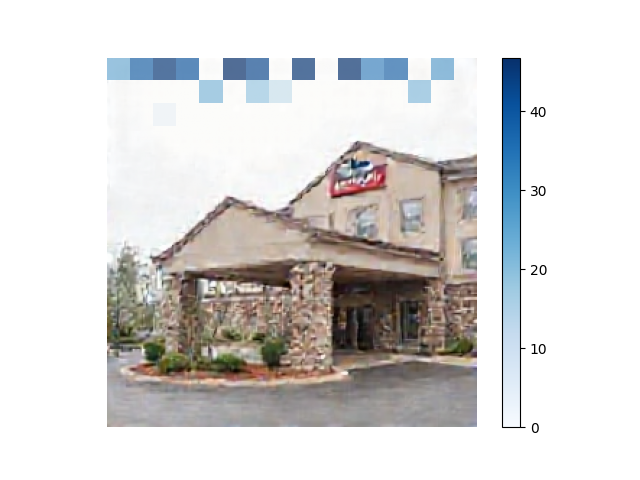

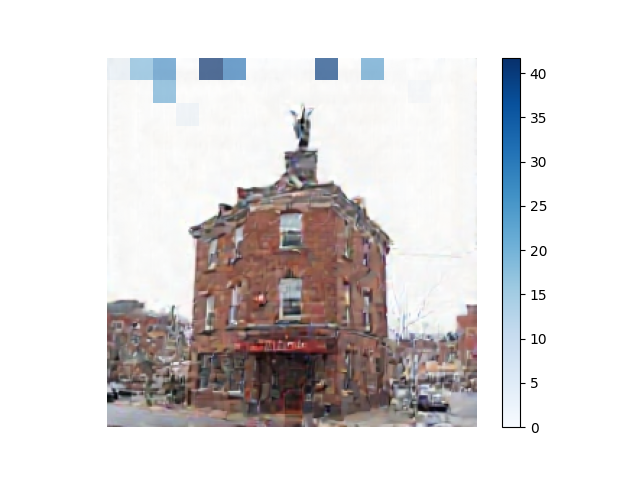

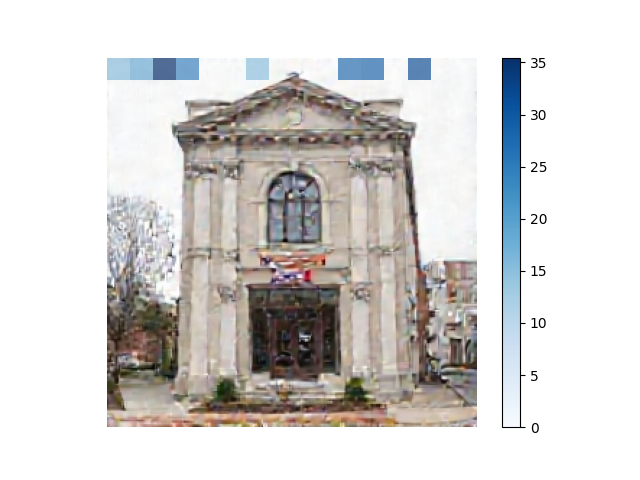

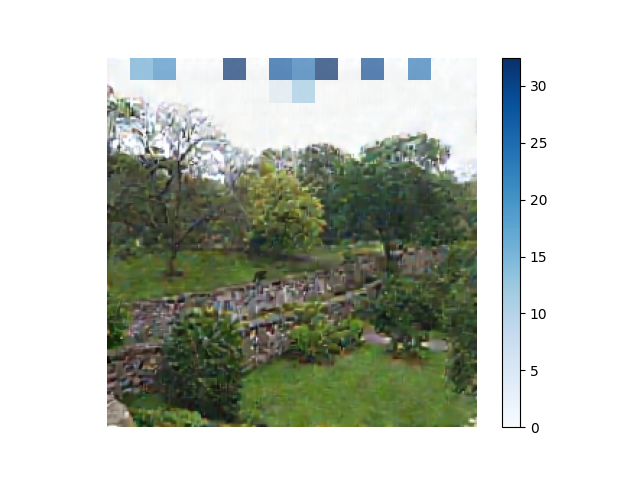

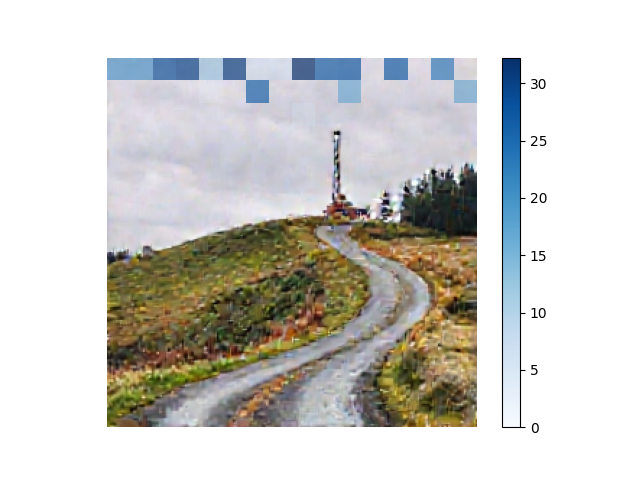

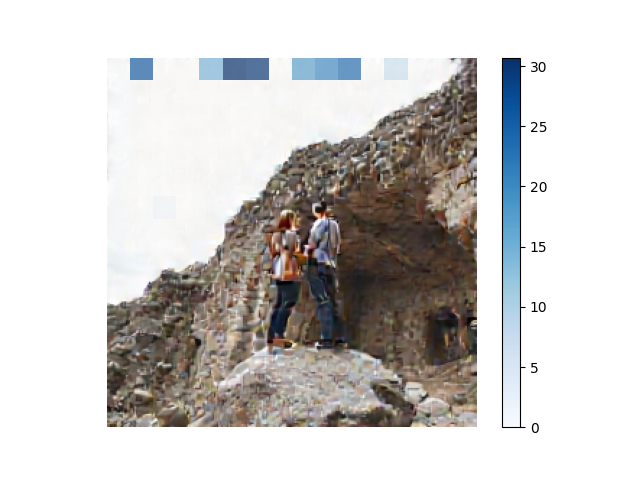

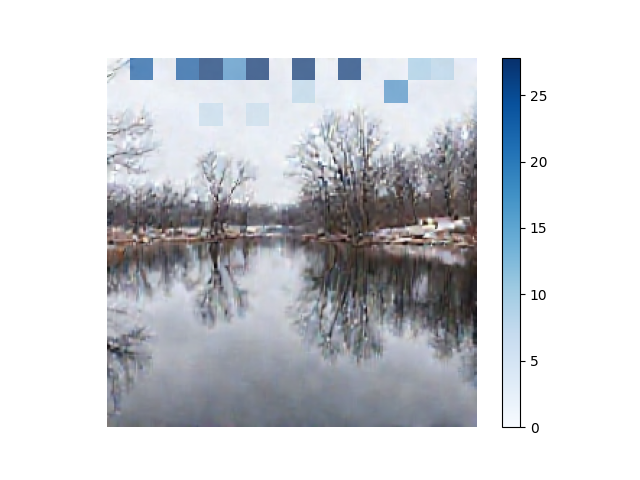

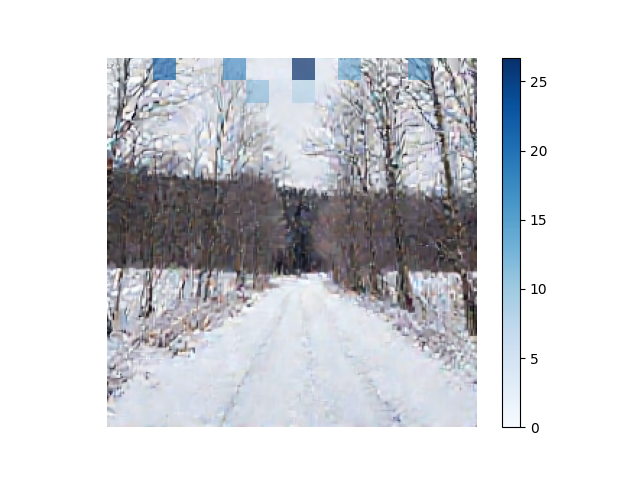

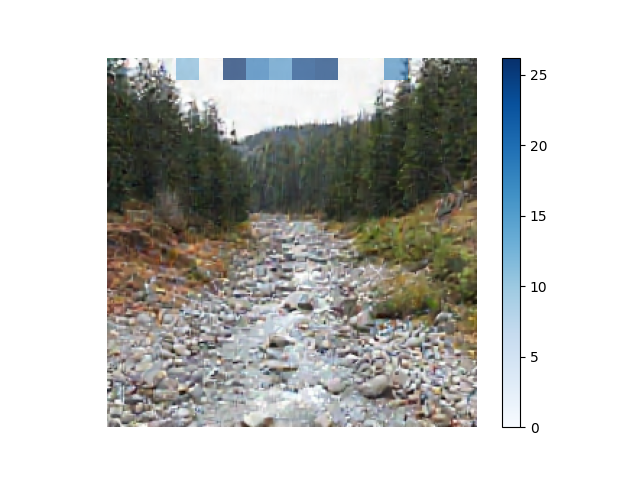

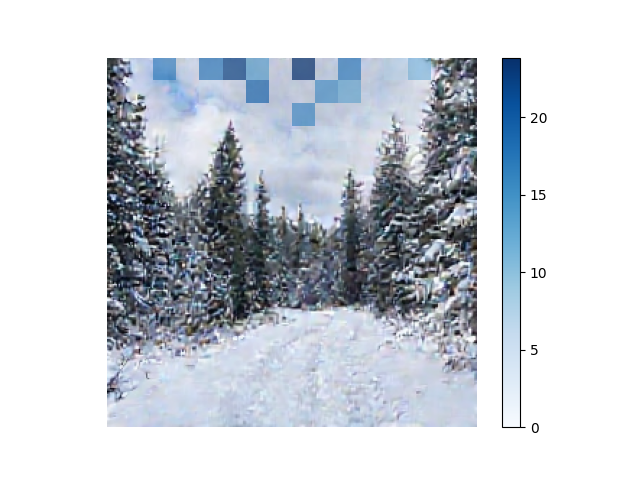

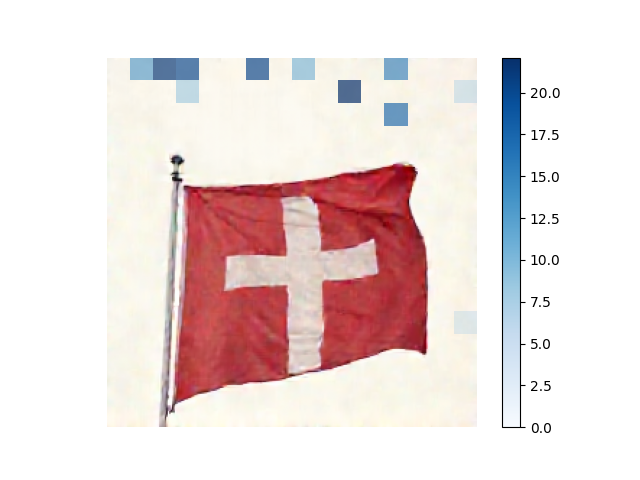

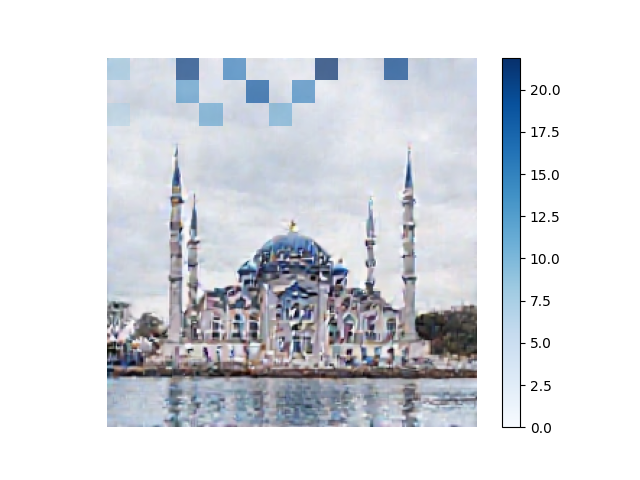

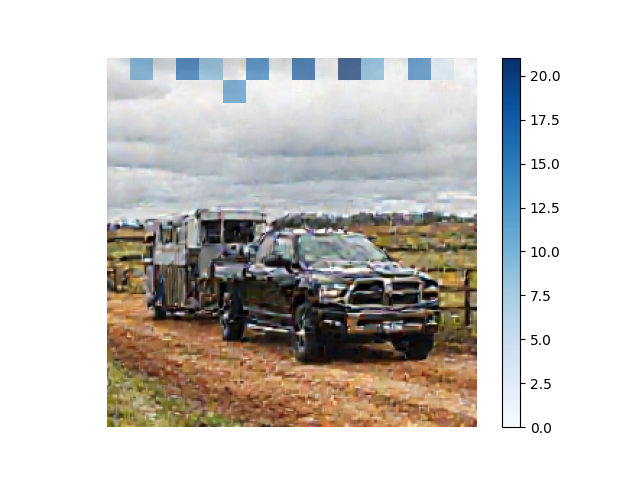

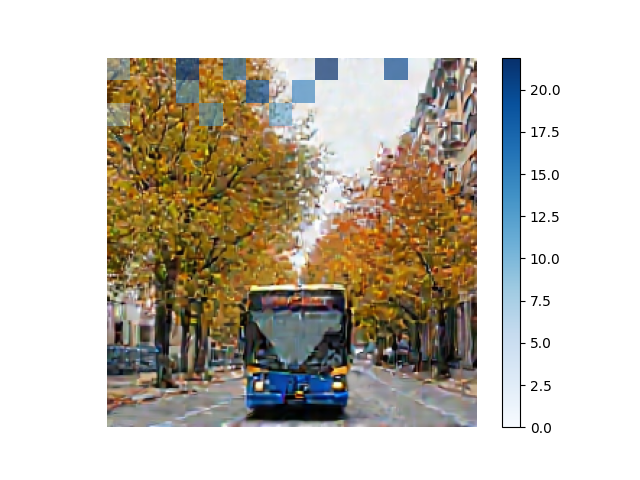

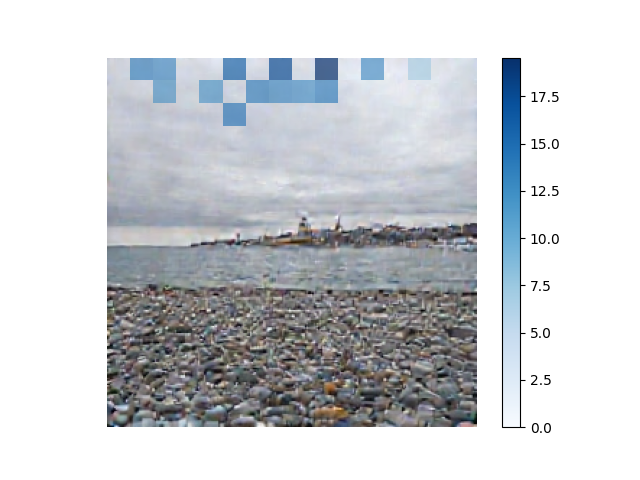

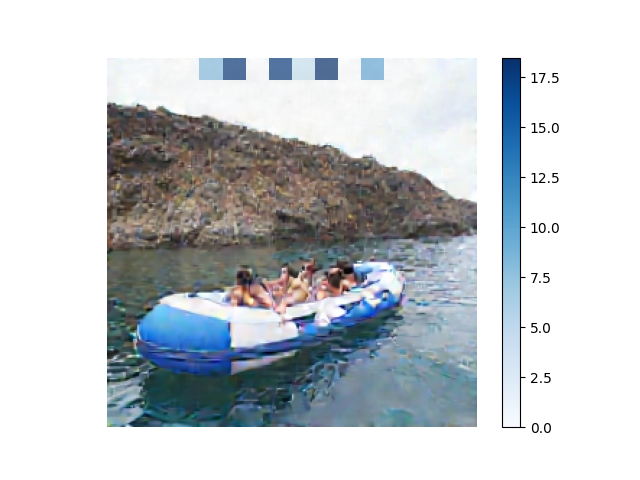

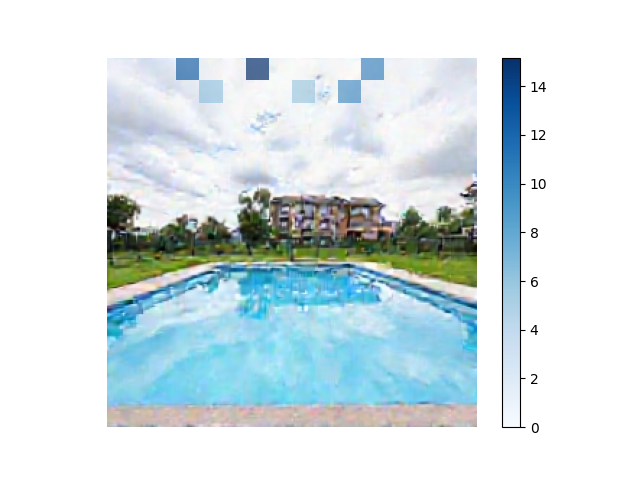

In [60]:

for x in maxacts(2926):
    display(x)

In [40]:
!du -h test.png

172K	test.png


In [37]:
feat_imgs[0].save("test.png")

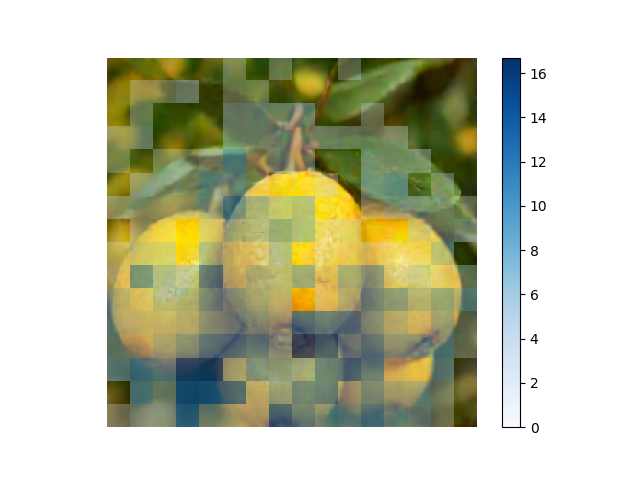

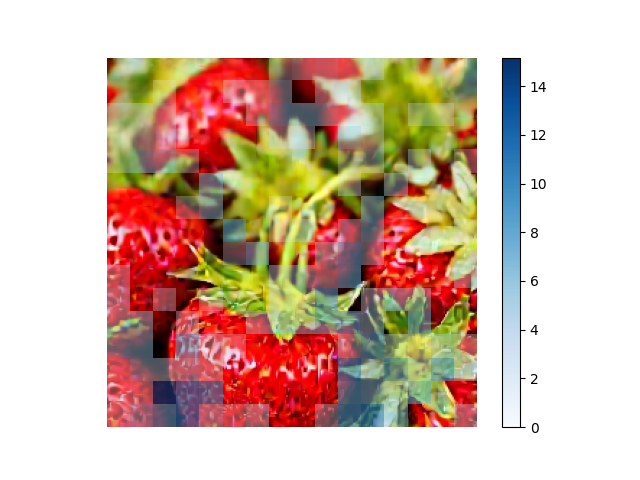

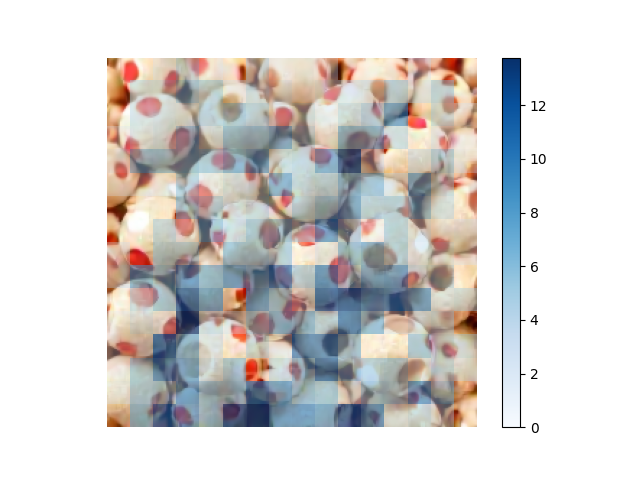

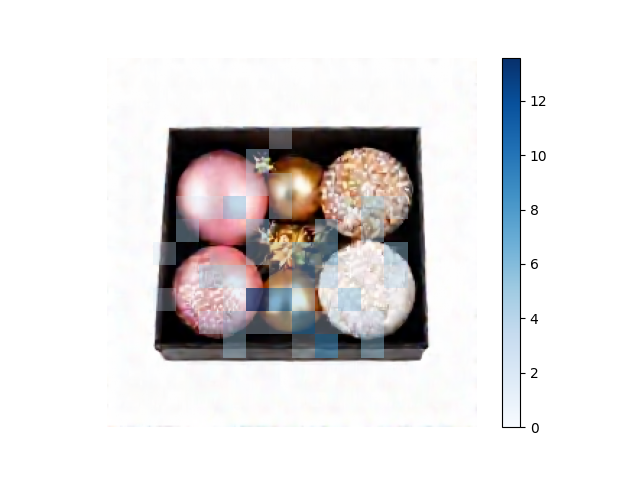

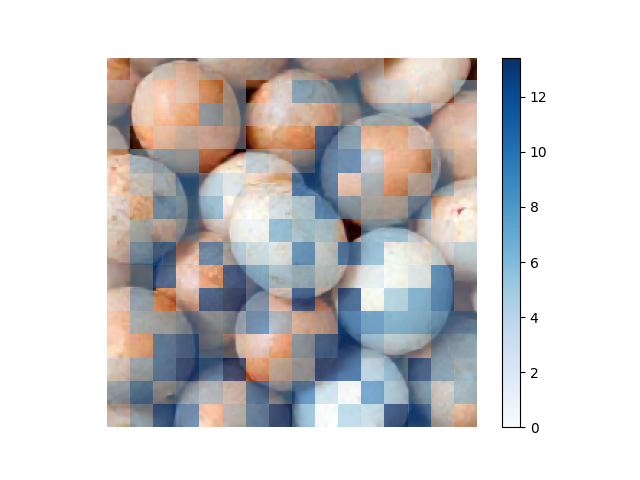

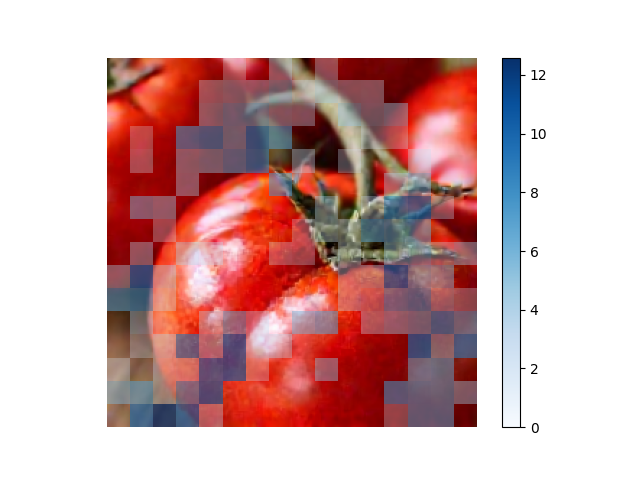

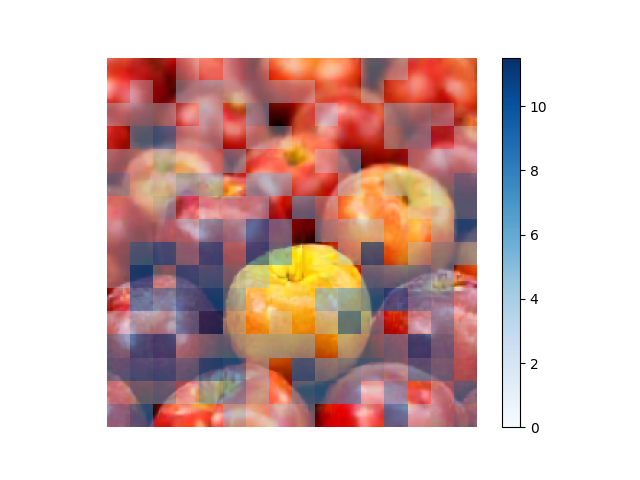

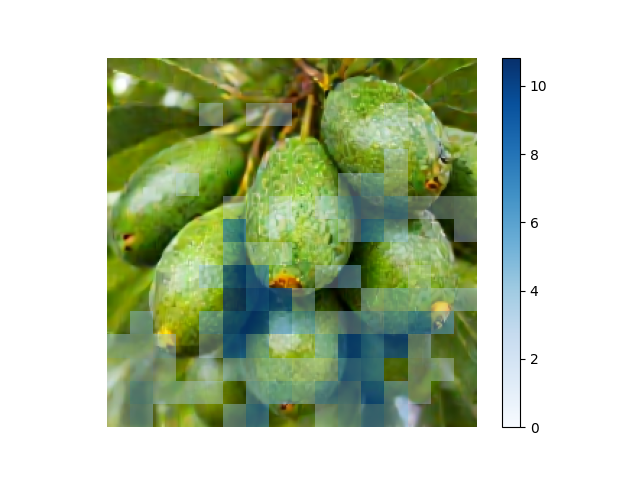

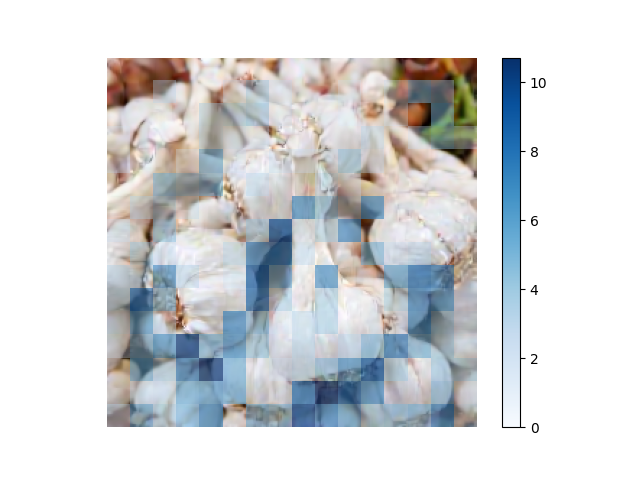

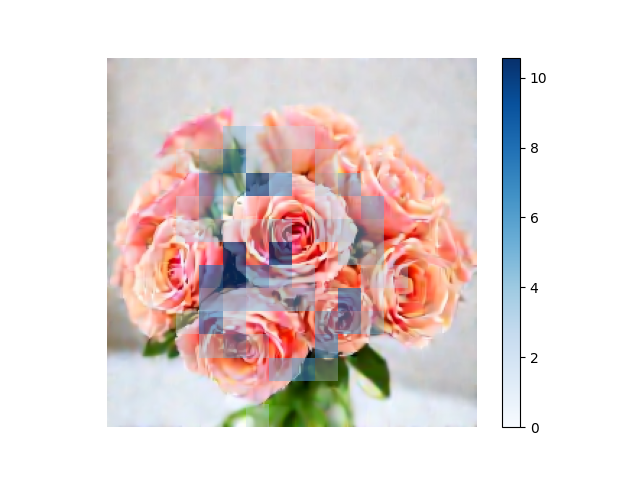

In [52]:
for x in feat_imgs:
    display(x)

In [36]:
from pydantic import BaseModel

activations_template = """You will be given a list of images.
Each image will have activations for a specific neuron highlighted in blue.
You should describe a common pattern or feature that the neuron is capturing.
First, write for each image, which parts are higlighted by the neuron.
Then, write a common pattern or feature that the neuron is capturing.
"""

class ActivationDescription(BaseModel):
    pattern_descriptions: list[str]
    common_pattern: str


def generate_activation_descriptions(images: list) -> str:
    # pil_images = [Image.fromarray(latent_to_img(img)) for img in images]
    pil_images = images
    encoded_images = [encode_image(pil_img) for pil_img in pil_images]

    messages = [{
        "role": "user",
        "content": [{
            "type": "text",
            "text": activations_template
        }]
    }]
    for encoded_image in encoded_images:
        messages.append({
            "role": "user",
            "content": [{
                "type": "image_url",
                "image_url": {
                    "url": f"data:image/jpeg;base64,{encoded_image}"
                }
            }]
        })

    response = completion(
        model="openai/google/gemini-2.0-flash-001",
        messages=messages,
        base_url="https://openrouter.ai/api/v1",
        response_format=ActivationDescription
    )

    return response.choices[0].message.content

In [ ]:
import json
from asyncio import gather

judge_template = """You will be given an image. And a neuron's activations description.
The image will have activations for the neuron highlighted in blue.
You should judge whether the description of the neuron's pattern is accurate or not.
Return a score between 0 and 1, where 1 means the description is accurate and 0 means it is not.
Be very critical. The pattern should be literal and specific, and vague or general descriptions should be rated low.
"""

class JudgeAnswer(BaseModel):
    score: float
    # justification: str

async def call_judge(image, pattern: list) -> dict:
    encoded_image = encode_image(image)

    messages = [{
        "role": "user",
        "content": [{
            "type": "text",
            "text": judge_template
        }, {
            "type": "image_url",
            "image_url": {
                "url": f"data:image/jpeg;base64,{encoded_image}"
            }
        }]
    }]

    for p in pattern:
        messages.append({
            "role": "user",
            "content": [{
                "type": "text",
                "text": p
            }]
        })

    response = await acompletion(
        model="openai/google/gemini-2.0-flash-001",
        messages=messages,
        base_url="https://openrouter.ai/api/v1",
        response_format=JudgeAnswer
    )

    return json.loads(response.choices[0].message.content)

async def judge_activation_descriptions(images: list, pattern: str) -> list:
    calls = [call_judge(image, pattern) for image in images]

    calls = await gather(*calls)

    return calls

    

In [38]:
import json

descriptions = json.loads(generate_activation_descriptions(feat_imgs))

In [60]:
await judge_activation_descriptions(feat_imgs, descriptions["common_pattern"])

[{'score': 0.9},
 {'score': 0.0},
 {'score': 0.9},
 {'score': 0.8},
 {'score': 0.9},
 {'score': 0.6},
 {'score': 0.6},
 {'score': 0.7},
 {'score': 0.9},
 {'score': 0.6}]

In [40]:
descriptions

{'common_pattern': 'The neuron seems to be activated by images containing round objects with a light color.',
 'pattern_descriptions': ['The neuron is activated by yellow, round fruits.',
  'The neuron is activated by red, round fruits.',
  'The neuron is activated by white, round fruits.',
  'The neuron is activated by round ornaments in a box.',
  'The neuron is activated by round, mottled fruits.',
  'The neuron is activated by red, round fruits.',
  'The neuron is activated by red and yellow, round fruits.',
  'The neuron is activated by green, round fruits.',
  'The neuron is activated by white, round fruits.',
  'The neuron is activated by pink, round flowers.']}

In [41]:
import json

with open("results.json") as f:
    image_counts = json.load(f)

(array([1252.,  920., 1039., 1041., 1080., 1077., 1018.,  958.,  884.,
         786.,  791.,  711.,  704.,  609.,  550.,  523.,  498.,  463.,
         392.,  371.,  324.,  317.,  267.,  272.,  267.,  224.,  205.,
         182.,  166.,  182.,  179.,  159.,  145.,  153.,  139.,  135.,
         131.,   94.,  108.,  116.,  105.,   91.,   92.,   79.,   58.,
          76.,   69.,   62.,   64.,   69.,   47.,   64.,   49.,   62.,
          50.,   54.,   54.,   49.,   41.,   37.,   29.,   40.,   36.,
          48.,   34.,   37.,   21.,   37.,   34.,   28.,   20.,   28.,
          28.,   24.,   14.,   21.,   20.,   18.,   16.,   16.,   15.,
          18.,   13.,   32.,   24.,   13.,   21.,   11.,   10.,   18.,
          11.,   19.,   19.,   18.,   11.,   13.,   11.,    5.,   14.,
           9.]),
 array([  1.  ,   6.99,  12.98,  18.97,  24.96,  30.95,  36.94,  42.93,
         48.92,  54.91,  60.9 ,  66.89,  72.88,  78.87,  84.86,  90.85,
         96.84, 102.83, 108.82, 114.81, 120.8 , 126.79, 13

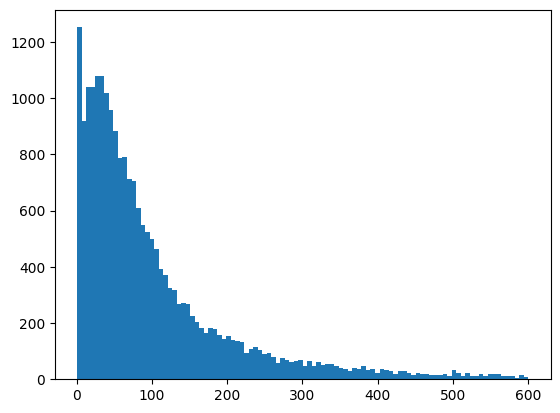

In [42]:
import matplotlib.pyplot as plt

plt.hist(image_counts, bins=100, range=(1, 600))

In [46]:
sum(image_counts) * 172 // 1024 // 1024

412

In [9]:
from collections import Counter

Counter(image_counts)[0]

43507